In [1]:
# We need to import these modules to get started
import os
import platform
import pandas as pd
import numpy as np
from sklearn import preprocessing
import analysis_utils
import warnings
from event_utils import get_events
from create_stim_table import create_stim_df
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

# This patch of code just ensures we get an easy to read font size for the duration of the notebook
import matplotlib
font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

In [2]:
# Set file location based on platform. 
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')

# Create data cache object 
boc = BrainObservatoryCache(manifest_file=manifest_file)

In [4]:
desired_container_id = 688678764

In [5]:
desired_container = boc.get_ophys_experiments(experiment_container_ids=[desired_container_id])
desired_container = sorted(desired_container, key=lambda x: x['session_type']) # sort based on session type so A comes first

session_indices_by_stimulus = {"drifting_gratings":"0",
                              "static_gratings":"1",
                              "natural_scenes":"1",
                              "natural_movie_one":["0","1","2"],
                              "natural_movie_three":"0"}

In [6]:
# Get session IDs for each session
session_id = desired_container[int(session_indices_by_stimulus["natural_movie_one"][0])]["id"]

# Get all event traces for all neurons in given session 
all_events = analysis_utils.get_events(boc, session_id, "VISp")

# Get full stimulus table for a given session
stim_table = analysis_utils.create_stim_df(boc, session_id)

# Isolate natural movie one stimulus table
stim_table = stim_table[stim_table.stim_category == "natural_movie_one"]

# Get mean response matrix, first for 30 bins
mean_responses1 = analysis_utils.get_mean_response_matrix_movie(session_id, desired_container_id, 30, boc)

# Same for response matrices for next two days for total of three response matrices
session_id = desired_container[int(session_indices_by_stimulus["natural_movie_one"][1])]["id"]
all_events = analysis_utils.get_events(boc, session_id, "VISp")
stim_table = analysis_utils.create_stim_df(boc, session_id)
mean_responses2 = analysis_utils.get_mean_response_matrix_movie(session_id, desired_container_id, 30, boc)

session_id = desired_container[int(session_indices_by_stimulus["natural_movie_one"][2])]["id"]
all_events = analysis_utils.get_events(boc, session_id, "VISp")
stim_table = analysis_utils.create_stim_df(boc, session_id)
mean_responses3 = analysis_utils.get_mean_response_matrix_movie(session_id, desired_container_id, 30, boc)


In [7]:
# Transform data
transformed_data, pca_results = analysis_utils.pca_transform_data(mean_responses1, mean_responses2, mean_responses3, 12)

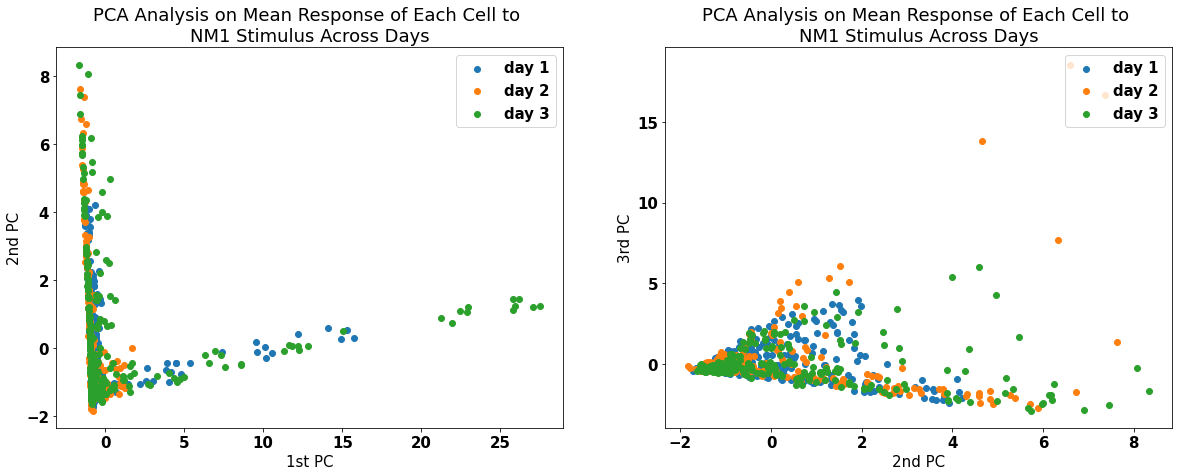

In [8]:
# PCA Model: 2D Visualization
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))

ax1.scatter(transformed_data[transformed_data.Session=="1"][0], transformed_data[transformed_data.Session=="1"][1], label="day 1")
ax1.scatter(transformed_data[transformed_data.Session=="2"][0], transformed_data[transformed_data.Session=="2"][1], label="day 2")
ax1.scatter(transformed_data[transformed_data.Session=="3"][0], transformed_data[transformed_data.Session=="3"][1], label="day 3")
ax1.set_xlabel("1st PC")
ax1.set_ylabel("2nd PC")
ax1.set_title("PCA Analysis on Mean Response of Each Cell to \nNM1 Stimulus Across Days")
ax1.legend(loc="upper right")

ax2.scatter(transformed_data[transformed_data.Session=="1"][1], transformed_data[transformed_data.Session=="1"][2], label="day 1")
ax2.scatter(transformed_data[transformed_data.Session=="2"][1], transformed_data[transformed_data.Session=="2"][2], label="day 2")
ax2.scatter(transformed_data[transformed_data.Session=="3"][1], transformed_data[transformed_data.Session=="3"][2], label="day 3")
ax2.set_xlabel("2nd PC")
ax2.set_ylabel("3rd PC")
ax2.set_title("PCA Analysis on Mean Response of Each Cell to \nNM1 Stimulus Across Days")
ax2.legend(loc="upper right")
plt.show()


In [9]:
# Get transformed data for each session
transformed_data1 = transformed_data[transformed_data.Session=='1']
transformed_data2 = transformed_data[transformed_data.Session=='2']
transformed_data3 = transformed_data[transformed_data.Session=='3']

In [10]:
# Differences between sessions in PC1
diff12_pc1 = transformed_data1[0]-transformed_data2[0]
diff13_pc1 = transformed_data1[0]-transformed_data3[0]
diff23_pc1 = transformed_data2[0]-transformed_data3[0]

# Differences between sessions in PC2
diff12_pc2 = transformed_data1[1]-transformed_data2[1]
diff13_pc2 = transformed_data1[1]-transformed_data3[1]
diff23_pc2 = transformed_data2[1]-transformed_data3[1]

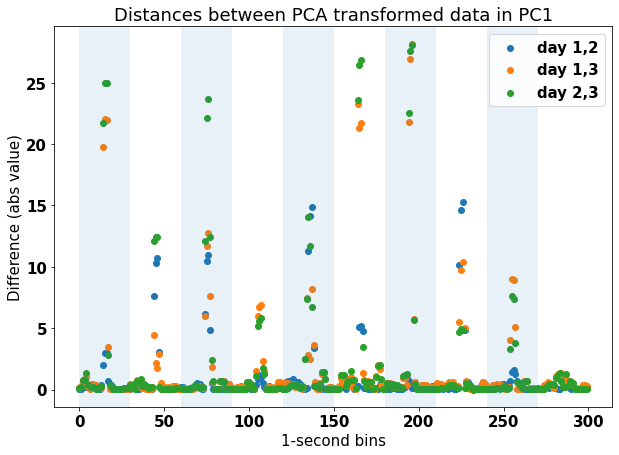

In [11]:
fig, ax = plt.subplots(figsize=(10,7))
plt.scatter(range(len(diff12_pc1)), abs(diff12_pc1), label = "day 1,2")
plt.scatter(range(len(diff13_pc1)), abs(diff13_pc1), label = "day 1,3")
plt.scatter(range(len(diff23_pc1)), abs(diff23_pc1), label = "day 2,3")
plt.title("Distances between PCA transformed data in PC1")
plt.xlabel("1-second bins")
plt.ylabel("Difference (abs value)")
plt.axvspan(0,30, alpha=0.1)
plt.axvspan(60,90, alpha=0.1)
plt.axvspan(120,150, alpha=0.1)
plt.axvspan(180,210, alpha=0.1)
plt.axvspan(240,270, alpha=0.1)
plt.legend()
plt.show()

In [12]:
# Look at frames where the differences are large
diff12_pc1_df = pd.DataFrame(diff12_pc1)
diff12_pc1_df = diff12_pc1_df.rename(columns={0:'difference'})
big_diff12_pc1_df = diff12_pc1_df[abs(diff12_pc1_df.difference) > 2.5]

In [13]:
# View indices (1 second intervals) where difference is greater than 2.5
big_diff12_pc1_df.index

Index([ 15,  16,  44,  45,  46,  47,  74,  75,  76,  77, 135, 136, 137, 138,
       165, 166, 167, 224, 225, 226, 227],
      dtype='int64')

In [14]:
# Transform indices (1 second intervals) to original 30 frame intervals
nm_template_indices = big_diff12_pc1_df.index * 30
nm_template_indices

Index([ 450,  480, 1320, 1350, 1380, 1410, 2220, 2250, 2280, 2310, 4050, 4080,
       4110, 4140, 4950, 4980, 5010, 6720, 6750, 6780, 6810],
      dtype='int64')

In [15]:
def cycle_indices(template_indices):
    '''
    Helper function to convert frame indices into seconds of the movie
    as each movie is 30s or 900 frames long.
    '''
    adjusted_indices = []
    for index in template_indices:
        if index < 900:
            adjusted_indices.append(index)
        if index > 900 and index < 1800:
            adjusted_indices.append(index-900)
        if index > 1800 and index < 2700:
            adjusted_indices.append(index-1800)
        if index > 2700 and index < 3600:
            adjusted_indices.append(index-2700)
        if index > 3600 and index < 4500:
            adjusted_indices.append(index-3600)
        if index > 4500 and index < 5400:
            adjusted_indices.append(index-4500)
        if index > 5400 and index < 6300:
            adjusted_indices.append(index-5300)
        if index > 6300 and index < 7200:
            adjusted_indices.append(index-6300)
    return adjusted_indices

In [16]:
# See which parts of the movie are repeated
adjusted_indices = cycle_indices(list(nm_template_indices))
np.asarray(adjusted_indices)

array([450, 480, 420, 450, 480, 510, 420, 450, 480, 510, 450, 480, 510,
       540, 450, 480, 510, 420, 450, 480, 510])

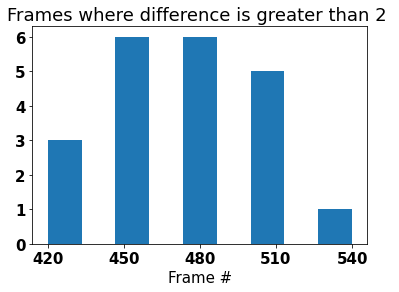

In [17]:
# View frequencies of frame numbers with big differences
plt.hist(np.asarray(adjusted_indices), bins=9)
plt.xticks(np.arange(420,570,30))
plt.xlabel("Frame #")
plt.title("Frames where difference is greater than 2 ")
plt.show()

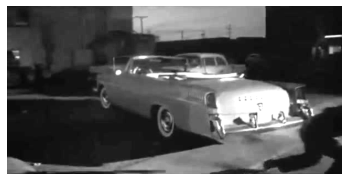

In [18]:
# View first frame with big difference
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id) # load in data
natural_movie_template = data_set.get_stimulus_template('natural_movie_one')
plt.imshow(natural_movie_template[420,:,:], cmap='gray')
plt.axis('off');

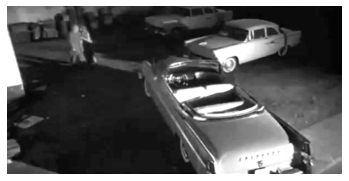

In [19]:
# View last frame with big difference
natural_movie_template = data_set.get_stimulus_template('natural_movie_one')
plt.imshow(natural_movie_template[510,:,:], cmap='gray')
plt.axis('off');

MovieWriter ffmpeg unavailable; using Pillow instead.


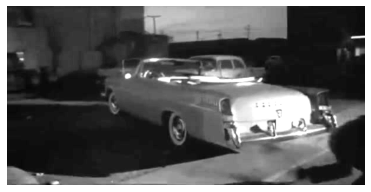

In [21]:
# Save movie for presentation
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(6.4, 3.6))
frame = 0
im = plt.imshow(movie[frame], cmap = "gray")

def update(*args):
    global frame
    im.set_array(movie[frame])
    frame += 1
    frame %= len(movie)
    #plt.title(frame)
    plt.axis('off')
    return im

movie = natural_movie_template[420:510,:,:]
ani = matplotlib.animation.FuncAnimation(fig, update, frames=90, interval=33)
ani.save('../movie_drift_pc1.gif')

In [22]:
# Look at differences in second PC

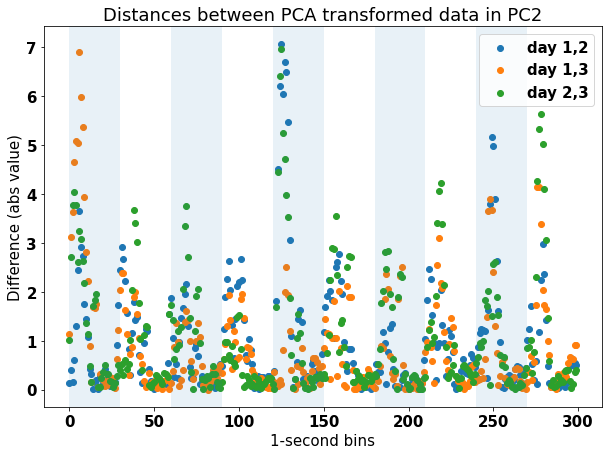

In [23]:
fig, ax = plt.subplots(figsize=(10,7))
plt.scatter(range(len(diff12_pc2)), abs(diff12_pc2), label = "day 1,2")
plt.scatter(range(len(diff13_pc2)), abs(diff13_pc2), label = "day 1,3")
plt.scatter(range(len(diff23_pc2)), abs(diff23_pc2), label = "day 2,3")
plt.title("Distances between PCA transformed data in PC2")
plt.xlabel("1-second bins")
plt.ylabel("Difference (abs value)")
plt.axvspan(0,30, alpha=0.1)
plt.axvspan(60,90, alpha=0.1)
plt.axvspan(120,150, alpha=0.1)
plt.axvspan(180,210, alpha=0.1)
plt.axvspan(240,270, alpha=0.1)
plt.legend()
plt.show()

In [24]:
# Look at frame differences
diff12_pc2_df = pd.DataFrame(diff12_pc2)
diff12_pc2_df = diff12_pc2_df.rename(columns={1:'difference'})
big_diff12_pc2_df = diff12_pc2_df[abs(diff12_pc2_df.difference) > 2.5]


In [25]:
# View indices (1 second intervals) where difference is greater than 2.5
big_diff12_pc2_df.index

Index([  6,   7,   8,  31,  32,  94, 101, 123, 124, 125, 126, 127, 128, 129,
       130, 157, 158, 159, 248, 249, 250, 251, 252, 279],
      dtype='int64')

In [26]:
adjusted_indices2 = cycle_indices(list(big_diff12_pc2_df.index * 30))
np.asarray(adjusted_indices2)

array([180, 210, 240,  30,  60, 120, 330,  90, 120, 150, 180, 210, 240,
       270, 300, 210, 240, 270])

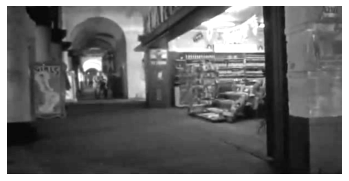

In [27]:
# View first frame with big difference
plt.imshow(natural_movie_template[30,:,:], cmap='gray') # 60 - 270
plt.axis('off');

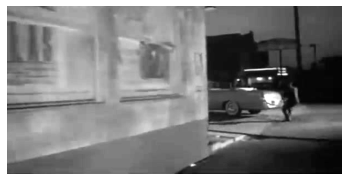

In [28]:
# View second frame with big difference
plt.imshow(natural_movie_template[270,:,:], cmap='gray')
plt.axis('off');

MovieWriter ffmpeg unavailable; using Pillow instead.


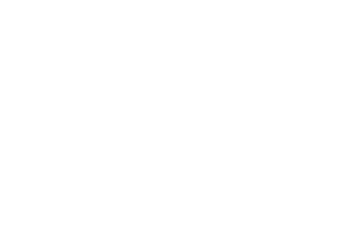

In [29]:
# Save for presentation
movie = natural_movie_template[30:270,:,:]
ani = matplotlib.animation.FuncAnimation(fig, update, frames=270 - 60, interval=33)
ani.save('../movie_drift_pc2.gif')

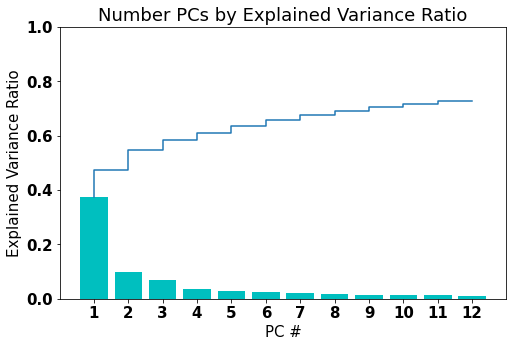

In [30]:
# Number of PCs by explained variance ratio
fig = plt.subplots(figsize=(8,5))
for i in range(1,13):
    plt.bar(i, pca_results.explained_variance_ratio[0][i-1], color="c")
plt.step(range(1,13), np.cumsum(pca_results.explained_variance_ratio[0]))
plt.ylim([0,1])
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.title("Number PCs by Explained Variance Ratio")
plt.xlabel("PC #")
plt.ylabel("Explained Variance Ratio")
# plt.savefig(f"../{desired_container_id}_dg_pca_explained_variance.jpg", dpi=200)
plt.show()

In [31]:
# Scale data to see if there are overwhelming contributions from few neurons

In [32]:
from sklearn.preprocessing import StandardScaler

# create a scaler object
std_scaler = StandardScaler()

# transform the data
response1_scaled = pd.DataFrame(std_scaler.fit_transform(mean_responses1))
response2_scaled = pd.DataFrame(std_scaler.fit_transform(mean_responses2))
response3_scaled = pd.DataFrame(std_scaler.fit_transform(mean_responses3))

# Transform data
transformed_data_scaled, pca_results_scaled = analysis_utils.pca_transform_data(response1_scaled, response2_scaled, response3_scaled, 12)

In [33]:
# Get transformed data for each session
transformed_data_scaled1 = transformed_data_scaled[transformed_data_scaled.Session=='1']
transformed_data_scaled2 = transformed_data_scaled[transformed_data_scaled.Session=='2']
transformed_data_scaled3 = transformed_data_scaled[transformed_data_scaled.Session=='3']

In [34]:
# Differences between sessions in PC1
diff12_pc1_scaled = transformed_data_scaled1[0]-transformed_data_scaled2[0]
diff13_pc1_scaled = transformed_data_scaled1[0]-transformed_data_scaled3[0]
diff23_pc1_scaled = transformed_data_scaled2[0]-transformed_data_scaled3[0]

# Differences between sessions in PC2
diff12_pc2_scaled = transformed_data_scaled1[1]-transformed_data_scaled2[1]
diff13_pc2_scaled = transformed_data_scaled1[1]-transformed_data_scaled3[1]
diff23_pc2_scaled = transformed_data_scaled2[1]-transformed_data_scaled3[1]

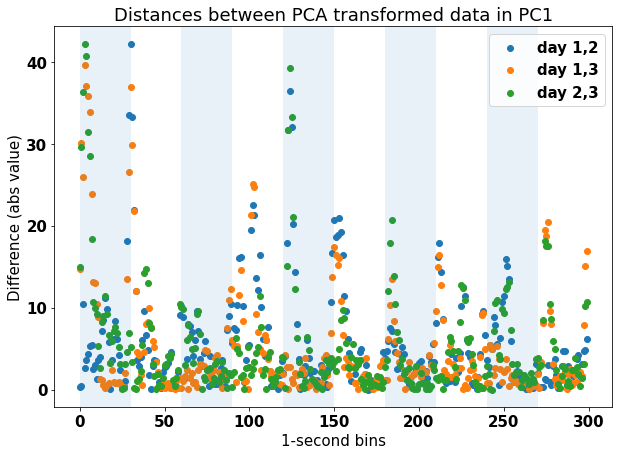

In [35]:
fig, ax = plt.subplots(figsize=(10,7))
plt.scatter(range(len(diff12_pc1_scaled)), abs(diff12_pc1_scaled), label = "day 1,2")
plt.scatter(range(len(diff13_pc1_scaled)), abs(diff13_pc1_scaled), label = "day 1,3")
plt.scatter(range(len(diff23_pc1_scaled)), abs(diff23_pc1_scaled), label = "day 2,3")
plt.title("Distances between PCA transformed data in PC1")
plt.xlabel("1-second bins")
plt.ylabel("Difference (abs value)")
plt.axvspan(0,30, alpha=0.1)
plt.axvspan(60,90, alpha=0.1)
plt.axvspan(120,150, alpha=0.1)
plt.axvspan(180,210, alpha=0.1)
plt.axvspan(240,270, alpha=0.1)
plt.legend()
plt.show()

In [36]:
# The fact that there is more variability in the scaled model suggests that the larger clear differences
# in the non-scaled plot above is due to a small subset of neurons producing the greatest change 

# See which neurons have the strongest response for frames 420 to 510 

In [ ]:
# Re-extract all events with 1-frame bins in desired frames

In [46]:
# Re-extract all events with 1-frame bins in desired frames
session_id = desired_container[int(session_indices_by_stimulus["natural_movie_one"][1])]["id"]
all_events = analysis_utils.get_events(boc, session_id, "VISp")
stim_table = analysis_utils.create_stim_df(boc, session_id)
mean_responses1 = analysis_utils.get_mean_response_matrix_movie(session_id, desired_container_id, 1, boc)

# Same for response matrices for next two days for total of three response matrices
session_id = desired_container[int(session_indices_by_stimulus["natural_movie_one"][1])]["id"]
all_events = analysis_utils.get_events(boc, session_id, "VISp")
stim_table = analysis_utils.create_stim_df(boc, session_id)
mean_responses2 = analysis_utils.get_mean_response_matrix_movie(session_id, desired_container_id, 1, boc)

session_id = desired_container[int(session_indices_by_stimulus["natural_movie_one"][2])]["id"]
all_events = analysis_utils.get_events(boc, session_id, "VISp")
stim_table = analysis_utils.create_stim_df(boc, session_id)
mean_responses3 = analysis_utils.get_mean_response_matrix_movie(session_id, desired_container_id, 1, boc)

In [81]:
# Isolate responses to desired frame that elicits large difference to see which neuron has larger responses
first_presentation_mean_responses1 = mean_responses1[0:900,:]
desired_frames_mean_responses1 = first_presentation_mean_responses1[420:510,:]

first_presentation_mean_responses2 = mean_responses2[0:900,:]
desired_frames_mean_responses2 = first_presentation_mean_responses2[420:510,:]

first_presentation_mean_responses3 = mean_responses3[0:900,:]
desired_frames_mean_responses3 = first_presentation_mean_responses3[420:510,:]

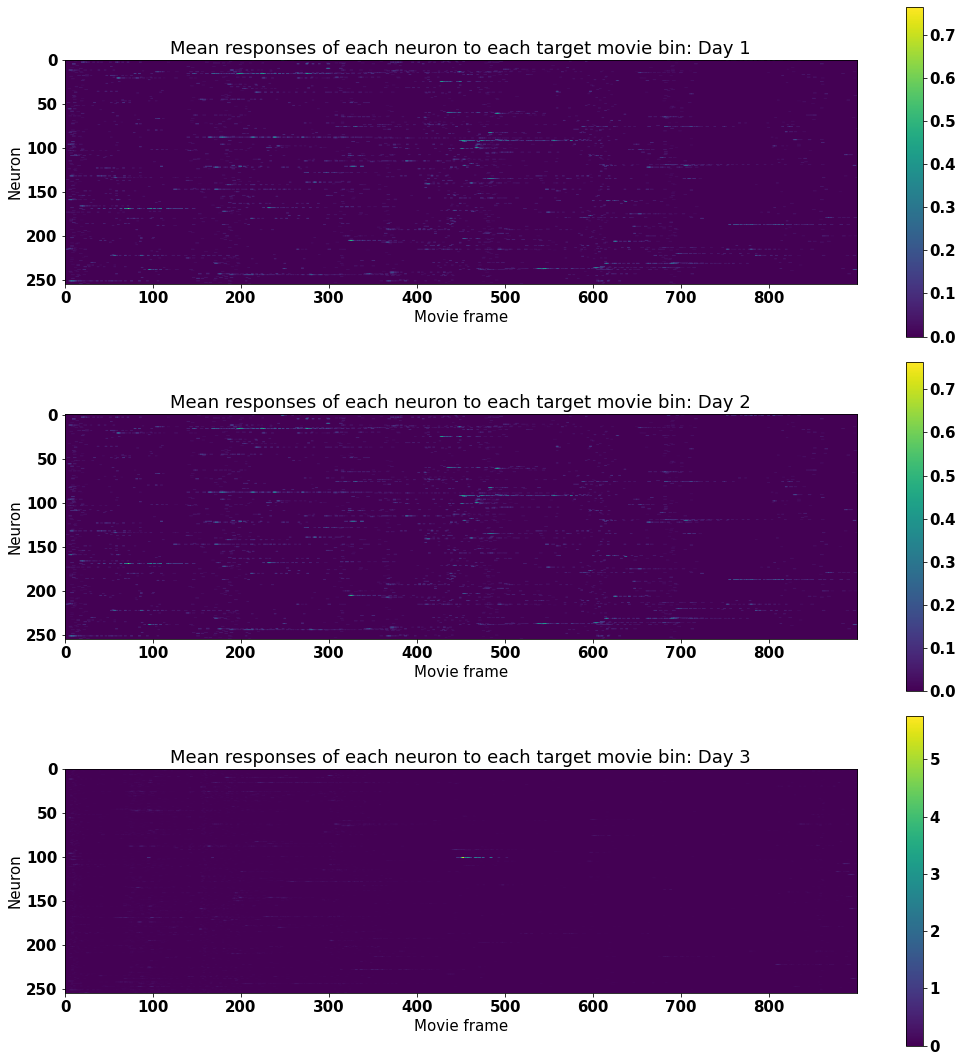

In [88]:
# Plot heat map data for one full movie presentation

# Plot heat map data
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize = (15,15))
im = ax1.imshow(first_presentation_mean_responses1.T)
fig.colorbar(im, ax=ax1)
#ax.set_yticks([0,1,2])
ax1.set_ylabel("Neuron")
ax1.set_xlabel("Movie frame")
ax1.set_title("Mean responses of each neuron to each target movie bin: Day 1")


# Plot heat map data
im = ax2.imshow(first_presentation_mean_responses2.T)
fig.colorbar(im, ax=ax2)
#ax.set_yticks([0,1,2])
ax2.set_ylabel("Neuron")
ax2.set_xlabel("Movie frame")
ax2.set_title("Mean responses of each neuron to each target movie bin: Day 2")
plt.tight_layout()

# Plot heat map data
im = ax3.imshow(first_presentation_mean_responses3.T)
fig.colorbar(im, ax=ax3)
#ax.set_yticks([0,1,2])
ax3.set_ylabel("Neuron")
ax3.set_xlabel("Movie frame")
ax3.set_title("Mean responses of each neuron to each target movie bin: Day 3")
plt.tight_layout()
plt.show()

In [ ]:
# Plot normalized responses 

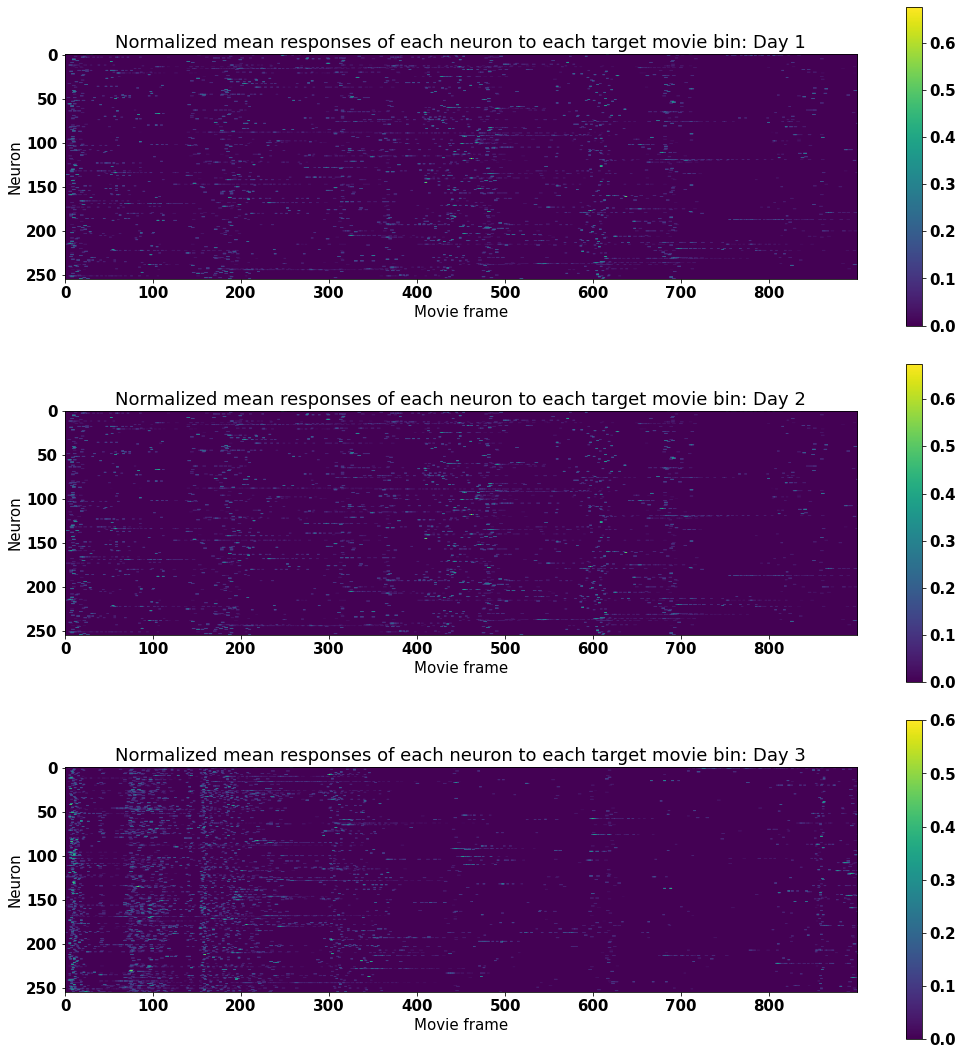

In [91]:

# Plot heat map data
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize = (15,15))
im = ax1.imshow(preprocessing.normalize(first_presentation_mean_responses1.T))
fig.colorbar(im, ax=ax1)
#ax.set_yticks([0,1,2])
ax1.set_ylabel("Neuron")
ax1.set_xlabel("Movie frame")
ax1.set_title("Normalized mean responses of each neuron to each target movie bin: Day 1")


# Plot heat map data
im = ax2.imshow(preprocessing.normalize(first_presentation_mean_responses2.T))
fig.colorbar(im, ax=ax2)
#ax.set_yticks([0,1,2])
ax2.set_ylabel("Neuron")
ax2.set_xlabel("Movie frame")
ax2.set_title("Normalized mean responses of each neuron to each target movie bin: Day 2")

# Plot heat map data
im = ax3.imshow(preprocessing.normalize(first_presentation_mean_responses3.T))
fig.colorbar(im, ax=ax3)
#ax.set_yticks([0,1,2])
ax3.set_ylabel("Neuron")
ax3.set_xlabel("Movie frame")
ax3.set_title("Normalized mean responses of each neuron to each target movie bin: Day 3")
plt.tight_layout()
plt.show()

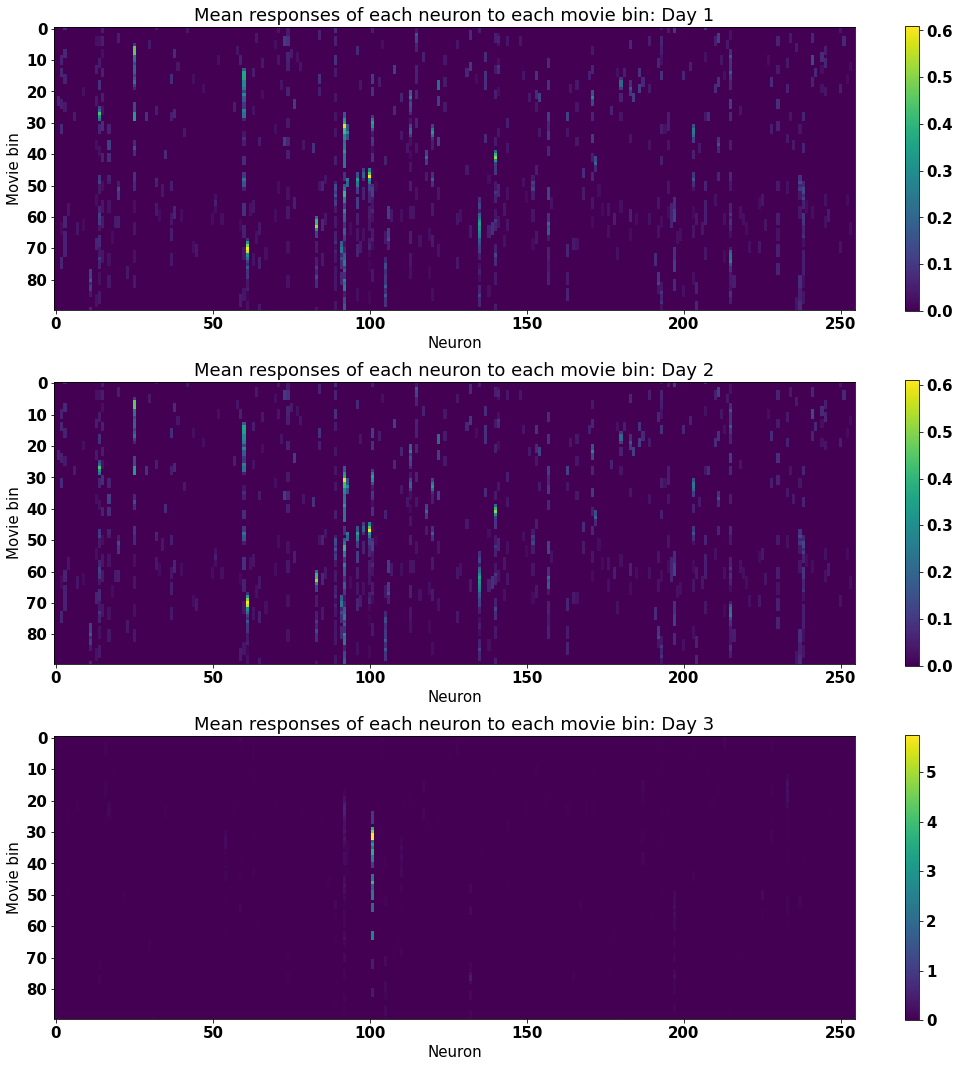

In [82]:
# Plot heat map data
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize = (15,15))
im = ax1.imshow(desired_frames_mean_responses1)
fig.colorbar(im, ax=ax1)
#ax.set_yticks([0,1,2])
ax1.set_ylabel("Movie bin")
ax1.set_xlabel("Neuron")
ax1.set_title("Mean responses of each neuron to each target movie bin: Day 1")


# Plot heat map data
im = ax2.imshow(desired_frames_mean_responses2)
fig.colorbar(im, ax=ax2)
#ax.set_yticks([0,1,2])
ax2.set_ylabel("Movie bin")
ax2.set_xlabel("Neuron")
ax2.set_title("Mean responses of each neuron to each target movie bin: Day 2")
plt.tight_layout()

# Plot heat map data
im = ax3.imshow(desired_frames_mean_responses3)
fig.colorbar(im, ax=ax3)
#ax.set_yticks([0,1,2])
ax3.set_ylabel("Movie bin")
ax3.set_xlabel("Neuron")
ax3.set_title("Mean responses of each neuron to each target movie bin: Day 3")
plt.tight_layout()
plt.show()

In [ ]:
# Normalize responses

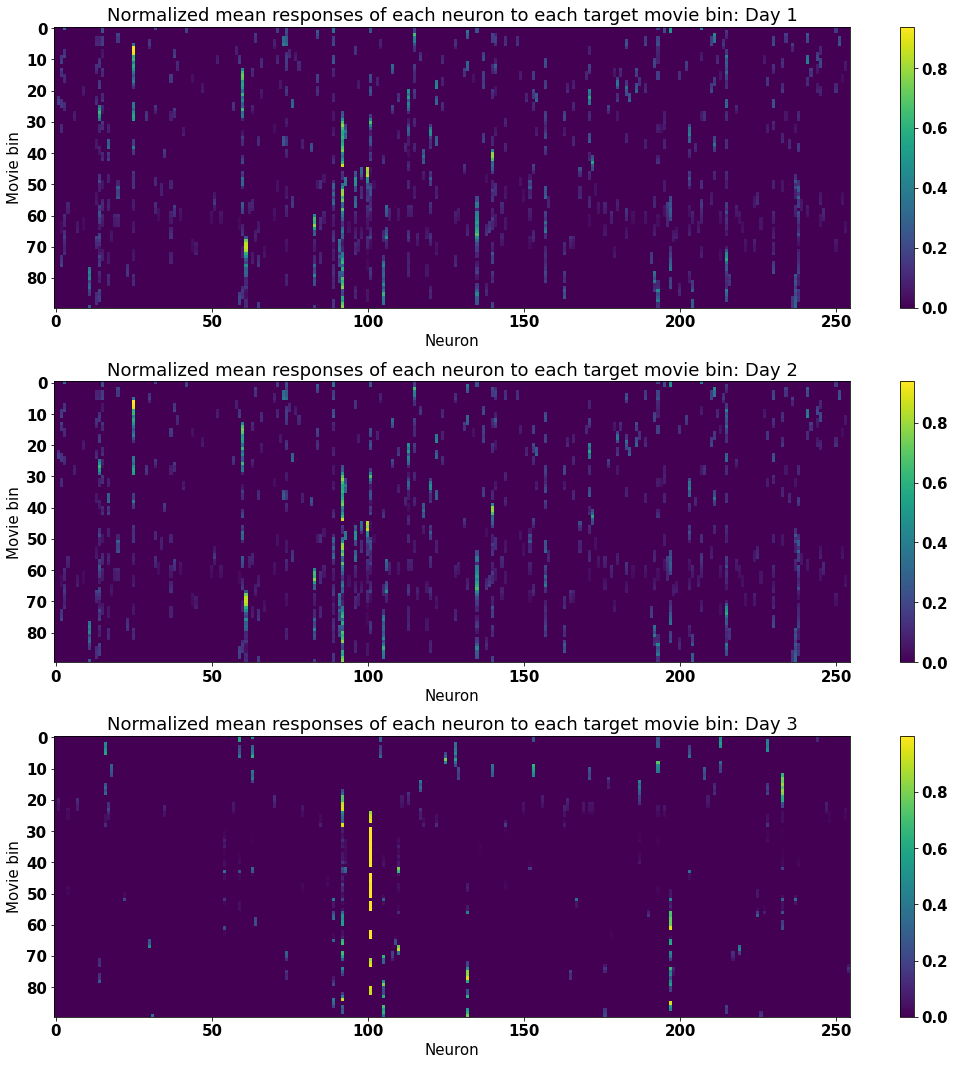

In [102]:
# Plot heat map data
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize = (15,15))
im = ax1.imshow(preprocessing.normalize(desired_frames_mean_responses1))
fig.colorbar(im, ax=ax1)
# ax1.set_xticks(np.arange(0,256,10))
ax1.set_ylabel("Movie bin")
ax1.set_xlabel("Neuron")
ax1.set_title("Normalized mean responses of each neuron to each target movie bin: Day 1")


# Plot heat map data
im = ax2.imshow(preprocessing.normalize(desired_frames_mean_responses2))
fig.colorbar(im, ax=ax2)
# ax2.set_xticks(np.arange(0,256,10))
ax2.set_ylabel("Movie bin")
ax2.set_xlabel("Neuron")
ax2.set_title("Normalized mean responses of each neuron to each target movie bin: Day 2")

# Plot heat map data
im = ax3.imshow(preprocessing.normalize(desired_frames_mean_responses3))
fig.colorbar(im, ax=ax3)
# ax3.set_xticks(np.arange(0,256,10))
ax3.set_ylabel("Movie bin")
ax3.set_xlabel("Neuron")
ax3.set_title("Normalized mean responses of each neuron to each target movie bin: Day 3")
plt.tight_layout()
plt.show()

In [ ]:
# Certain neurons appear to elicit stronger responses